In [79]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [80]:
import os.path
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import norm
import matplotlib.pyplot as plt
from sepia.SepiaModel import SepiaModel
from sepia.SepiaData import SepiaData
import sepia.SepiaPlot as SepiaPlot
from sepia.SepiaPredict import SepiaEmulatorPrediction

In [81]:
with open('data/bd_nobias_C_data.pkl','rb') as f:
    mvcData = pickle.load(f)

In [82]:
mvcData['Ydata']['sim']['orig'].T.shape

(578, 25)

In [83]:
data = SepiaData(x_sim = mvcData['XTdata']['sim']['X']['orig'],
                 t_sim = mvcData['XTdata']['sim']['T']['orig'],
                 y_sim = mvcData['Ydata']['sim']['orig'].T,
                 y_ind_sim = mvcData['YindSim'].squeeze(),
                 x_obs = mvcData['XTdata']['obs']['X']['orig'],
                 y_obs = mvcData['Ydata']['obs']['orig'].T,
                 y_ind_obs= mvcData['YindObs'].squeeze())

In [84]:
data.transform_xt()
data.standardize_y(scale='scalar')

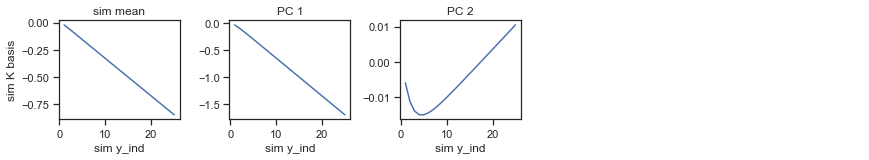

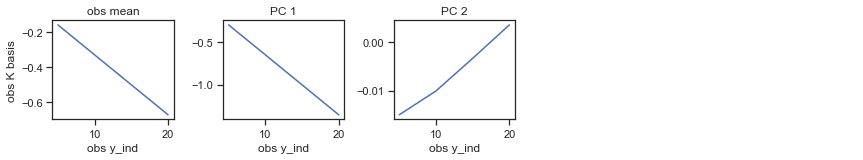

In [85]:
data.create_K_basis(2)
fig_sim, fig_obs = SepiaPlot.plot_K_basis(data)

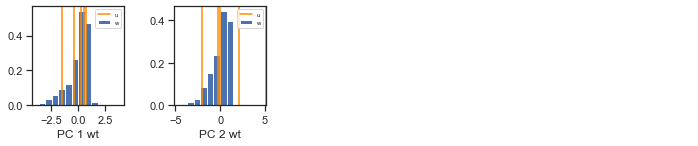

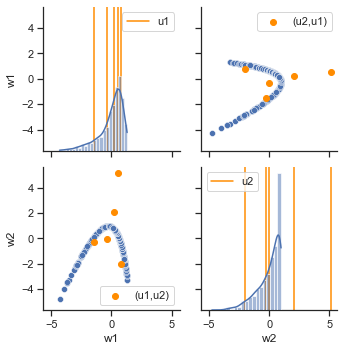

In [86]:
fig_uw = SepiaPlot.plot_K_weights(data)
fig_uw_pairs = SepiaPlot.plot_u_w_pairs(data)

In [88]:
model = SepiaModel(data)
nsamp = 10000
model.tune_step_sizes(50, 20)
model.do_mcmc(nsamp)

To use a D basis (normally recommended), call data.create_D_basis on your SepiaData object.
lamWOs initialized outside default bounds [60, 1e5]; setting initial value to 1e5 - 1.
Starting tune_step_sizes...
Default step sizes:
theta
[[0.2]]
betaU
[[0.1 0.1]
 [0.1 0.1]]
lamUz
[[5. 5.]]
lamWs
[[100. 100.]]
lamWOs
[[100.]]
lamOs
[[204.78110079]]


Step size tuning: 100%|██████████| 50/50 [01:57<00:00,  2.35s/it]


Done with tune_step_size.
Selected step sizes:
theta
[[0.08757343]]
betaU
[[0.00728122 0.02902417]
 [0.07465394 0.29771223]]
lamUz
[[0.07370666 0.07505987]]
lamWs
[[72315.18815898  8802.5503399 ]]
lamWOs
[[83.97759037]]
lamOs
[[839.88888265]]


MCMC sampling: 100%|██████████| 10000/10000 [24:54<00:00,  6.69it/s]


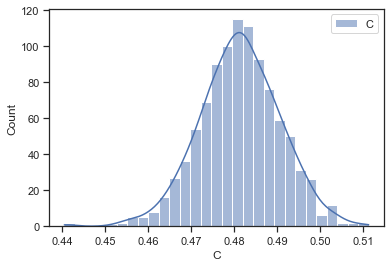

In [89]:
#thined = np.linspace(1000,10000,1000,endpoint=False,dtype='int')
samples_dict = model.get_samples(nburn=0)
with open('data/bd_nobias_sepia_578_samples.pkl','wb') as f:
    pickle.dump(samples_dict['theta'],f)
theta_pairs = SepiaPlot.theta_pairs(samples_dict, ['C'], native=False)

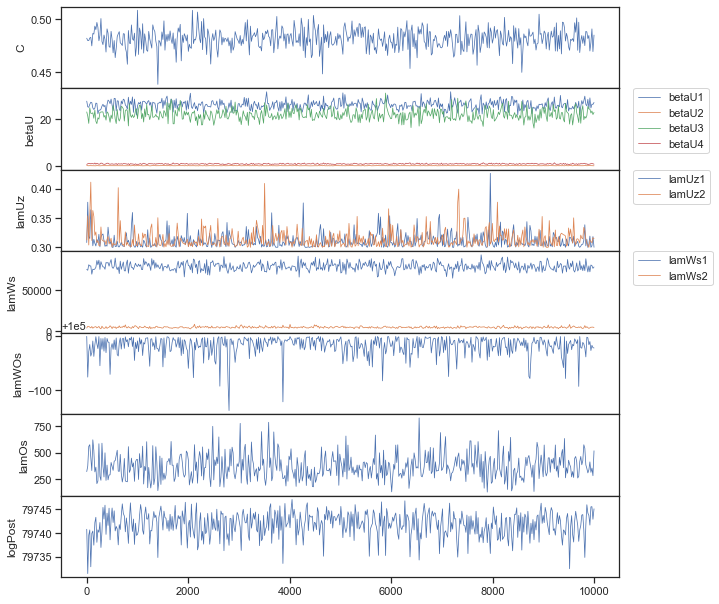

In [90]:
mcmc_trace = SepiaPlot.mcmc_trace(samples_dict,['C'])

In [91]:
p_stats = SepiaPlot.param_stats(samples_dict,theta_names=['C'],q1=.05,q2=.95,digits=4)
print(p_stats)

                    mean         sd  0.05 quantile  0.95 quantile
C                 0.4814     0.0095         0.4657         0.4967
betaU_1          25.9195     1.7852        23.0837        28.8870
betaU_2           0.2390     0.0332         0.1877         0.2968
betaU_3          21.7720     2.3025        18.2096        25.8664
betaU_4           1.0232     0.1639         0.7784         1.3098
lamUz_1           0.3112     0.0122         0.3004         0.3353
lamUz_2           0.3144     0.0148         0.3007         0.3428
lamWs_1       79055.7684  4850.1009     71150.3681     87054.8852
lamWs_2        4691.8044   924.8835      3306.3619      6301.3353
lamWOs        99982.7864    18.4106     99945.9374     99999.4409
lamOs           368.9886   116.9436       201.3640       584.0900
logPost       79741.8778     2.7650     79736.8006     79745.6704
theta_native      0.0981     0.0010         0.0965         0.0996


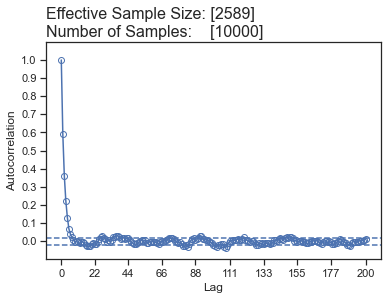

In [92]:
acf = SepiaPlot.plot_acf(model,200)

Max effective sample size over thetas: 2275
Total samples: 10000


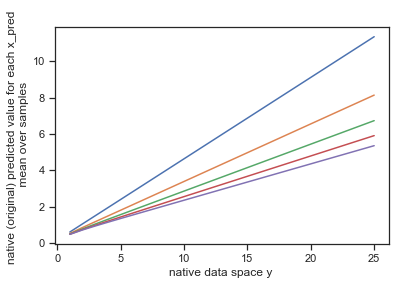

In [93]:
model.verbose=True
x_pred=data.obs_data.x
n_pred=x_pred.shape[0]
pred_samples=model.get_samples(nburn=int(.1*nsamp),effectivesamples=True)
pred=SepiaEmulatorPrediction(x_pred=x_pred, samples=pred_samples, model=model)#, t_pred=t_pred)
predy=pred.get_y()
plt.figure()
plt.plot(model.data.sim_data.y_ind,np.mean(predy,0).T)
plt.xlabel('native data space y ')
plt.ylabel('native (original) predicted value for each x_pred \n mean over samples')
plt.show()

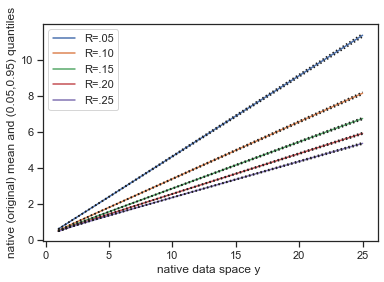

In [94]:
plt.figure()
plt.plot(model.data.sim_data.y_ind,np.mean(predy[:,0,:],0).T,label='R=.05')
plt.plot(model.data.sim_data.y_ind,np.mean(predy[:,1,:],0).T,label='R=.10')
plt.plot(model.data.sim_data.y_ind,np.mean(predy[:,2,:],0).T,label='R=.15')
plt.plot(model.data.sim_data.y_ind,np.mean(predy[:,3,:],0).T,label='R=.20')
plt.plot(model.data.sim_data.y_ind,np.mean(predy[:,4,:],0).T,label='R=.25')
plt.plot(model.data.sim_data.y_ind,np.quantile(predy[:,0,:],[0.05, 0.95],axis=0).T,'k:')
plt.plot(model.data.sim_data.y_ind,np.quantile(predy[:,1,:],[0.05, 0.95],axis=0).T,'k:')
plt.plot(model.data.sim_data.y_ind,np.quantile(predy[:,2,:],[0.05, 0.95],axis=0).T,'k:')
plt.plot(model.data.sim_data.y_ind,np.quantile(predy[:,3,:],[0.05, 0.95],axis=0).T,'k:')
plt.plot(model.data.sim_data.y_ind,np.quantile(predy[:,4,:],[0.05, 0.95],axis=0).T,'k:')
plt.xlabel('native data space y ')
plt.ylabel('native (original) mean and (0.05,0.95) quantiles')
plt.legend()
plt.show()

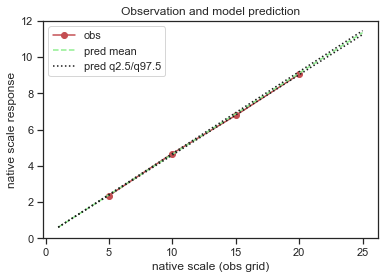

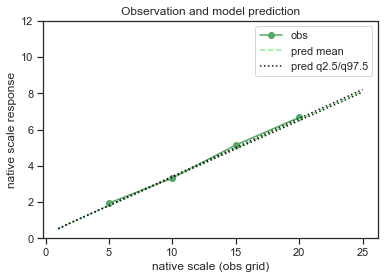

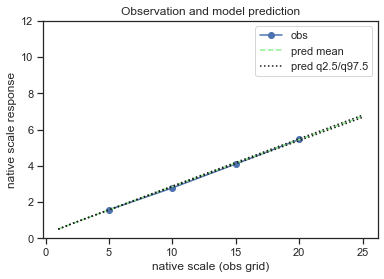

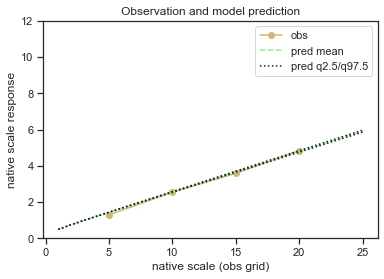

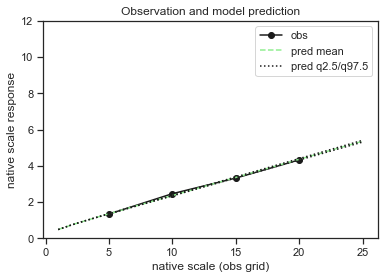

In [95]:
predysim=pred.get_y()
colors = ('r','g','b','y','k')
for R_idx in range(5):
    plt.figure()
    plt.plot(model.data.obs_data.y_ind,model.data.obs_data.y[R_idx,:],marker='o',color=colors[R_idx])
    plt.plot(model.data.sim_data.y_ind,np.mean(predysim[:,R_idx,:],0).T,'--',c='lightgreen')
    plt.plot(model.data.sim_data.y_ind,np.quantile(predysim[:,R_idx,:],.025,0),'k:')
    plt.plot(model.data.sim_data.y_ind,np.quantile(predysim[:,R_idx,:],.975,0),'k:')
    plt.xlabel('native scale (obs grid)')
    plt.ylabel('native scale response')
    plt.title('Observation and model prediction')
    plt.legend(['obs','pred mean','pred q2.5/q97.5'])
    plt.ylim(0,12)
    plt.show()

In [96]:
with open('data/bd_nobias_oos_C.pkl','rb') as f:
    mvcDataNew = pickle.load(f)

In [97]:
model.verbose=True
pred_samples=model.get_samples(nburn=int(.1*nsamp),effectivesamples=True)
pred_new=SepiaEmulatorPrediction(x_pred=mvcDataNew['XTdata']['obs']['X']['orig'], samples=pred_samples, model=model)#, t_pred=t_pred)

Max effective sample size over thetas: 2275
Total samples: 10000


In [98]:
predy_new = pred_new.get_y()

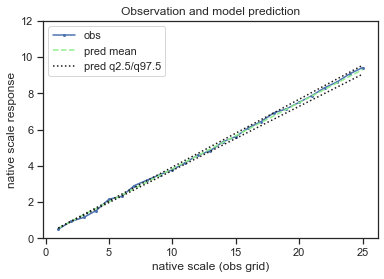

In [29]:
plt.figure()
plt.plot(model.data.obs_data.y_ind,mvcDataNew['Ydata']['obs']['orig'],marker='o',markersize=2)
plt.plot(model.data.obs_data.y_ind,np.mean(predy_new[:,0,:],0).T,'--',c='lightgreen')
plt.plot(model.data.obs_data.y_ind,np.quantile(predy_new[:,0,:],.025,0),'k:')
plt.plot(model.data.obs_data.y_ind,np.quantile(predy_new[:,0,:],.975,0),'k:')
plt.xlabel('native scale (obs grid)')
plt.ylabel('native scale response')
plt.title('Observation and model prediction')
plt.legend(['obs','pred mean','pred q2.5/q97.5'])
plt.ylim(0,12)
plt.show()